##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Convolutional Neural Network (CNN)

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/cnn">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/cnn.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/cnn.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/cnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Este tutorial demonstra o treinamento de uma Rede Neural Convolucional (CNN) simples para classificar imagens CIFAR . Como este tutorial usa a API Keras Sequential , criar e treinar seu modelo levará apenas algumas linhas de código.

### Importar TensorFlow

In [2]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

2022-12-14 02:35:18.952623: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 02:35:18.952732: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 02:35:18.952748: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


### Baixe e prepare o conjunto de dados CIFAR10

O conjunto de dados CIFAR10 contém 60.000 imagens coloridas em 10 classes, com 6.000 imagens em cada classe. O conjunto de dados é dividido em 50.000 imagens de treinamento e 10.000 imagens de teste. As classes são mutuamente exclusivas e não há sobreposição entre elas.

In [3]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

170498071/170498071 [==============================] - 3s 0us/step


### Verificar os dados

Para verificar se o conjunto de dados parece correto, vamos plotar as primeiras 25 imagens do conjunto de treinamento e exibir o nome da classe abaixo de cada imagem:


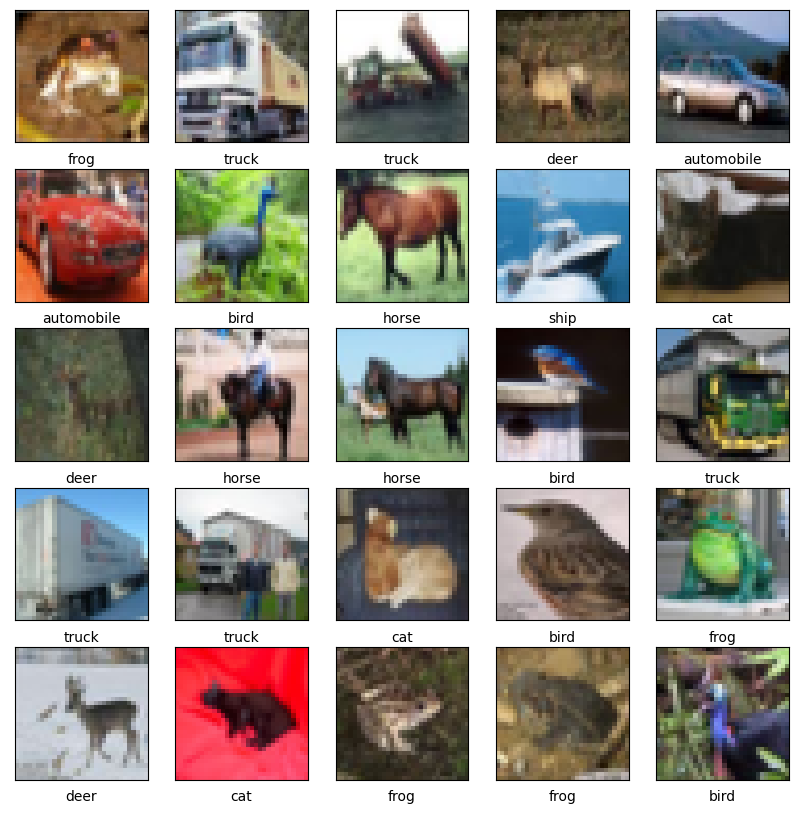

In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

### Create the convolutional base

As 6 linhas de código abaixo definem a base convolucional usando um padrão comum: uma pilha de camadas Conv2D e MaxPooling2D .

Como entrada, uma CNN recebe tensores de forma (image_height, image_width, color_channels), ignorando o tamanho do lote. Se você é novo nessas dimensões, color_channels se refere a (R,G,B). Neste exemplo, você configurará sua CNN para processar entradas de forma (32, 32, 3), que é o formato das imagens CIFAR. Você pode fazer isso passando o argumento `input_shape` para sua primeira camada.

In [5]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

Vamos exibir a arquitetura do seu modelo até agora:

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
Total params: 56,320
Trainable params: 56,320
Non-traina

Acima, você pode ver que a saída de cada camada Conv2D e MaxPooling2D é um tensor 3D de forma (altura, largura, canais). As dimensões de largura e altura tendem a diminuir à medida que você se aprofunda na rede. O número de canais de saída para cada camada Conv2D é controlado pelo primeiro argumento (por exemplo, 32 ou 64). Normalmente, à medida que a largura e a altura diminuem, você pode (computacionalmente) adicionar mais canais de saída em cada camada Conv2D.

### Adicione camadas densas no topo

Para completar o modelo, você alimentará o último tensor de saída da base convolucional (de forma (4, 4, 64)) em uma ou mais camadas densas para realizar a classificação. Camadas densas recebem vetores como entrada (que são 1D), enquanto a saída atual é um tensor 3D. Primeiro, você achatará (ou desenrolará) a saída 3D para 1D e, em seguida, adicionará uma ou mais camadas Densas no topo. O CIFAR tem 10 classes de saída, então você usa uma camada Dense final com 10 saídas.

In [7]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

Aqui está a arquitetura completa do seu modelo:

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)              0

O resumo da rede mostra que (4, 4, 64) as saídas foram achatadas em vetores de forma (1024) antes de passar por duas camadas Densas.

### Compilar e treinar o modelo

In [9]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 [==============================] - 10s 4ms/step - loss: 1.5316 - accuracy: 0.4406 - val_loss: 1.2891 - val_accuracy: 0.5438
Epoch 2/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.1786 - accuracy: 0.5810 - val_loss: 1.1129 - val_accuracy: 0.6107
Epoch 3/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.0249 - accuracy: 0.6390 - val_loss: 1.0288 - val_accuracy: 0.6382
Epoch 4/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.9256 - accuracy: 0.6734 - val_loss: 0.9192 - val_accuracy: 0.6806
Epoch 5/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.8491 - accuracy: 0.7019 - val_loss: 0.8938 - val_accuracy: 0.6849
Epoch 6/10
1563/1563 [==============================] - 7s 4ms/step - loss: 0.7900 - accuracy: 0.7233 - val_loss: 0.9419 - val_accuracy: 0.6702
Epoch 7/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.7399 - accuracy: 0.7398 - val_loss: 0.8676 - val_accuracy

### Avaliar o modelo

313/313 - 1s - loss: 0.8744 - accuracy: 0.7137 - 652ms/epoch - 2ms/step


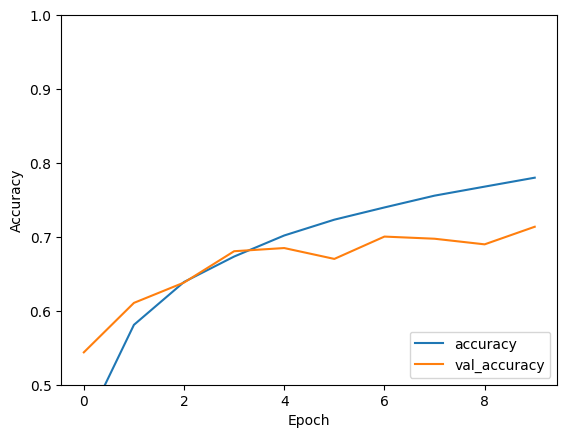

In [10]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [11]:
print(test_acc)

0.713699996471405
